# Graph Classification with Volumetric Tensor Features

This example demonstrates graph classification using volumetric data (e.g., 3D medical images) as node features.


📦 GNN Graph Classification: Volumetric Tensor Node Features

📈 Training for 15 epochs...
-----------------------------------------------------------------
Epoch |       Loss |    Accuracy (%)
-----------------------------------------------------------------
    1 |     0.7159 |           43.00
    2 |     0.6740 |           60.00
    3 |     0.6800 |           60.00
    4 |     0.6713 |           60.00
    5 |     0.6688 |           60.00
    6 |     0.6755 |           60.00
    7 |     0.6757 |           60.00
    8 |     0.6754 |           60.00
    9 |     0.6700 |           60.00
   10 |     0.6719 |           60.00
   11 |     0.6738 |           60.00
   12 |     0.6671 |           60.00
   13 |     0.6722 |           60.00
   14 |     0.6771 |           60.00
   15 |     0.6723 |           60.00


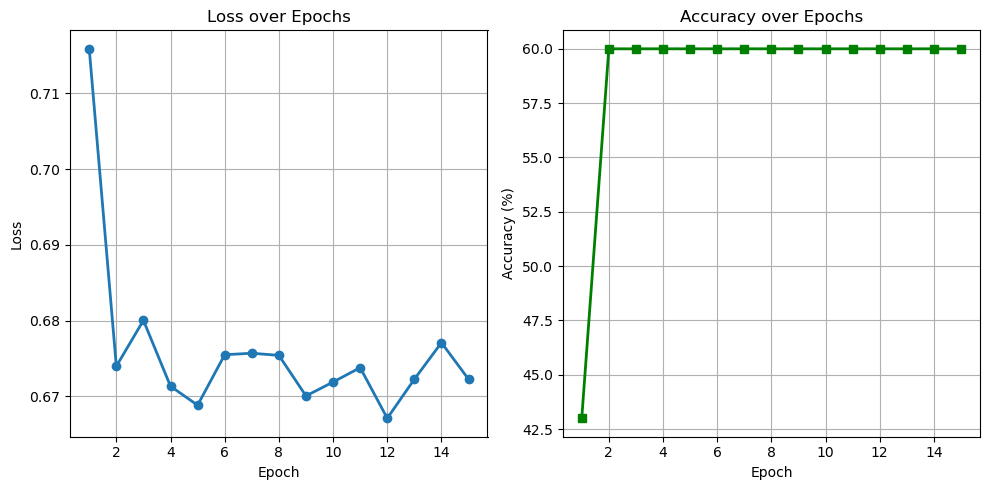


✅ Training Complete!
Final Loss     : 0.6723
Final Accuracy : 60.00%


In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models.graph_classifier import GraphClassifier
from core.graph import Graph, GraphBatch
from core.dataloader import GraphDataset, GraphDataLoader
from core.utils import get_device
import random

# ─────────────────────────────────────────────────────────────
# 🎯 Setup & Initialization
# ─────────────────────────────────────────────────────────────
print("\n" + "="*65)
print("📦 GNN Graph Classification: Volumetric Tensor Node Features")
print("="*65)

# Parameters for synthetic dataset
num_graphs = 100       # Generate 100 graphs
num_nodes = 5          # each with 5 nodes
num_edges = 8          # and 8 edges per graph
in_shape = (8, 10, 10, 10)       # Volumetric node features [C, D, H, W]
hidden_shape = (16, 10, 10, 10)  # Hidden shape
num_classes = 2
num_epochs = 15
lr = 0.001

graphs = []
labels_list = []
for i in range(num_graphs):
    node_features = torch.randn(num_nodes, *in_shape)
    edge_index = torch.randint(0, num_nodes, (2, num_edges))
    # Create graph and randomly assign a label (0 or 1)
    graph = Graph(node_features, edge_index)
    graphs.append(graph)
    labels_list.append(random.randint(0, num_classes-1))

# Device setup
device = get_device()
for graph in graphs:
    graph.to(device)

# Create dataset and dataloader
dataset = GraphDataset(graphs)
# Adjust batch_size as needed; here we use a batch size of 10 graphs
dataloader = GraphDataLoader(dataset, batch_size=10, shuffle=True)

# Model initialization
model = GraphClassifier(
    in_shape=in_shape,
    hidden_shape=hidden_shape,
    num_classes=num_classes,
    num_layers=2,
    pooling='mean'
)
model.to(device)

# Loss and Optimizer
# Convert labels_list to a tensor (will be used during training per batch)
labels_tensor = torch.tensor(labels_list, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

# ─────────────────────────────────────────────────────────────
# 📊 Training Loop
# ─────────────────────────────────────────────────────────────
print(f"\n📈 Training for {num_epochs} epochs...")
print("-"*65)
print(f"{'Epoch':>5} | {'Loss':>10} | {'Accuracy (%)':>15}")
print("-"*65)

loss_values = []
acc_values = []

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    # Iterate over batches
    for batch in dataloader:
        optimizer.zero_grad()
        # batch is a GraphBatch, and we need to get labels for graphs in this batch.
        # Let's assume graphs are in the same order as labels.
        batch_size = batch.batch.max().item() + 1
        # Create a batch labels tensor from the overall labels list:
        # (This is a simple approach; in a real scenario, you might include labels in the Graph object)
        batch_labels = labels_tensor[:batch_size]

        logits = model(
            batch.node_features,
            batch.edge_index,
            batch.edge_features,
            batch.batch
        )
        loss = loss_fn(logits, batch_labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_size
        preds = torch.argmax(logits, dim=1)
        epoch_correct += (preds == batch_labels).sum().item()
        epoch_total += batch_size

    epoch_loss /= epoch_total
    epoch_acc = 100.0 * epoch_correct / epoch_total
    loss_values.append(epoch_loss)
    acc_values.append(epoch_acc)
    print(f"{epoch:>5} | {epoch_loss:>10.4f} | {epoch_acc:>15.2f}")

# ─────────────────────────────────────────────────────────────
# 📈 Plotting Loss & Accuracy Curves
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linewidth=2)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), acc_values, marker='s', linewidth=2, color='green')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# ✅ Final Summary
# ─────────────────────────────────────────────────────────────
final_loss = loss_values[-1]
final_acc = acc_values[-1]
print("\n✅ Training Complete!")
print(f"Final Loss     : {final_loss:.4f}")
print(f"Final Accuracy : {final_acc:.2f}%")
print("="*65)
